# Zadanie 6 Pracownia Specjalistyczna - Eksploracja danych
### Krzysztof Funkowski

In [1]:
from math import *
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy

# Zadanie 6
- Konstrukcja klasyfikatora bayesowskiego na podstawie dwóch wielowymiarowych
rozkładów normalnych o takich samych i o różnych macierzach kowariancji
- Rozpatrzenie przypadków dla dwóch i trzech klas

### Funkcja do generowania zbioru danych na podstawie wielowymiarowego rozkładu normalnego

In [2]:
def generate_dataset_norm(N):
    return np.column_stack((np.random.normal(0, 0.3, N), np.random.normal(0, 0.3, N)))

### Funkcja do generowania zbioru danych wybierając dane z przedziału (0,1)
Wychodzi zbiór który na wykresie przyjmuje formę kwadratu

In [3]:
def generate_dataset_rand(N):
    dataset = []
    for _ in range(N):
        dataset.append([random.random(), random.random()])
        
    return dataset

### Funkcja do rotacji zbiorem danych na podstawie podanego kątu

In [4]:
def rotate(phi):
    rad = np.radians(phi)
    rotation_arr = np.array([[np.cos(rad), np.sin(rad)],
                             [-np.sin(rad), np.cos(rad)]])
    return rotation_arr

### Funkcja do rozciągania zbioru danych

In [5]:
def stretch(x, y):
    stretch_arr = np.array([[x, 0],
                            [0, y]])
    return stretch_arr

### Funkcja do transformacji zbioru danych

In [6]:
def perform_transformation(dataset, rotation_angle, x, y):
    result_dataset = copy.deepcopy(dataset)
    
    stretching = stretch(x, y)
    result_dataset = np.dot(result_dataset, stretching)
    
    rotation = rotate(rotation_angle)
    result_dataset = np.dot(result_dataset, rotation)
    
    return result_dataset

### Funkcja służąca do obliczania kowariancji dla dwóch wektorów

In [7]:
def cov(x, y, x_avg, y_avg):
    elements_count = len(x) # ilość elementów w tablicy
    elements_sum = 0
    
    for x,y in zip(x,y):
        elements_sum = elements_sum + ((x - x_avg)*(y - y_avg)) # sumowanie (x - średnia_arytmetyczna_x) * (y - średnia_arytmetyczna_y)
    
    return elements_sum / elements_count # suma dzielona przez liczbę elementów

### Funkcja obliczająca macierz kowariancji dla zbioru danych

In [8]:
def cov_for_dataset(cov_dataset):
    avgs = []
    matrix_shape = cov_dataset.shape[1] # wymiary_macierzy czyli liczba_kolumn_bioru_danych x liczba_kolumn_bioru_danych
    for i in range(matrix_shape):
        avgs.append(cov_dataset[:,i].mean()) # obliczanie średnich dla każdego parametru
    
    matrix = []
    for i in range(matrix_shape):
        matrix_row = []
        for j in range(matrix_shape):
            #matrix_shape*i + j
            res = cov(cov_dataset[:,i],cov_dataset[:,j],avgs[i], avgs[j]) # wyznaczanie kowariancji dla każdej pary parametrów
            matrix_row.append(res) # budowanie wiersza macierzy
        matrix.append(matrix_row) # dodawanie wiersza macierzy do tablicy bazowej
    
    return np.matrix(matrix) # przekształcanie typu tablicy na macierz

### Funkcja do obliczania długości wektora własnego

In [9]:
def eigenvector_len(v1):
    dims = v1.shape[0] # ilość elementów wektora
    length = 0
    
    for i in range(dims):
        val = v1[i].ravel().tolist()[0][0]
        length = length + pow(val,2) # sumowanie elementów podniesionych do kwadratu
        
    
    length = sqrt(length) # pierwiastkowanie wyniku sumy elementów wektora podniesionych do kwadratów
    
    return length # zwracanie długości

### Funkcja normalizująca, zwracająca wartość własną i wektor własny

In [10]:
def eigenvector_normalization(v1):
    eigenvalue = eigenvector_len(v1) # wylicznaie wartości własnej
    eigenvector = v1 / eigenvalue # wyliczanie wektora własnego
    
    return eigenvalue, eigenvector # zwrócenie wartości własnej i wektora własnego

### Pomocnicza funkcja zmieniająca tablicę wektorów własnych w odpowiednią formę macierzy

In [11]:
def rearrange_matrix(eigenvectors):
    res = []

    for i in range(len(eigenvectors)):
        row = eigenvectors[i].ravel().tolist()[0]
        res.append(row)

    return np.matrix(res).T

### Funkcja odpowiadająca za obliczanie wartości własnych i wektorów własnych

In [12]:
def eigenvalues_eigenvectors(matrix, num_iterations):
    n = matrix.shape[0] # jeden z wymiarów macierzy, ponieważ jest kwadratowa to wystarczy tylko jeden
    eigenvalues = [] # lista na wartości własne
    eigenvectors = [] # lista na wektory własne
    
    for i in range(n):
        # losowe dane wektora na początku
        eigenvector = np.random.rand(n,1)
    
        # algorytm iteracyjny wykonywany num_iterations razy
        for _ in range(num_iterations):
            eigenvector = np.dot(matrix, eigenvector) # mnożenie macierzy kowariancji przez wektor 
            eigenvalue, eigenvector = eigenvector_normalization(eigenvector) # normalizacja wektora
            
        # usuwanie z macierzy znalezionej wartości własnej i wektora własnego
        # marix - wartość własna * iloczyn zewnętrzny wektora własnego
        matrix = matrix - eigenvalue * np.multiply(eigenvector,eigenvector.T).T 
        
        eigenvalues.append(eigenvalue) # dodanie znalezionej wartości własnej do listy
        eigenvectors.append(eigenvector) # dodanie znalezionego wektora własnego do listy
        
        
        
    return eigenvalues, rearrange_matrix(eigenvectors) # zwrócenie wartości własnych i wektorów własnych

### Funkcja przeprowadzająca operacje wybielania na zbiorze danych

In [13]:
def whitening(dataset):
    cov_matrix = cov_for_dataset(dataset)
    
    num_iterations = 10000
    eigenvalues, eigenvectors = eigenvalues_eigenvectors(cov_matrix, num_iterations)
    K = eigenvectors
    
    A = np.identity(2) * eigenvalues
    A = np.linalg.inv(np.identity(2) * np.sqrt(eigenvalues)) # INV(I * wartości_własne)
    
    new_dataset = (A * K * np.array(dataset, dtype='double').T).T
    new_dataset = np.array(new_dataset)

    return new_dataset

### Generowanie zbiorów z taką samą kowariancją

In [35]:
dataset1 = np.array(generate_dataset_norm(100))
dataset2 = np.array(generate_dataset_norm(100))

### Sprawdzenie kowariancji przed wybielaniem

In [36]:
cov_for_dataset(dataset1)

matrix([[ 0.06326824, -0.00185851],
        [-0.00185851,  0.09210347]])

In [37]:
cov_for_dataset(dataset2)

matrix([[0.09342309, 0.00121706],
        [0.00121706, 0.08962659]])

### Wybielanie i macierze kowariancji po operacji

In [38]:
w1 = whitening(dataset1)
cov_for_dataset(w1)

matrix([[1.00000000e+00, 3.85802501e-17],
        [3.85802501e-17, 1.00000000e+00]])

In [39]:
w2 = whitening(dataset2)
cov_for_dataset(w2)

matrix([[ 1.00000000e+00, -6.66133815e-17],
        [-6.66133815e-17,  1.00000000e+00]])

### Transformacje i macierze kowariancji po operacji

In [40]:
t1 = perform_transformation(w1, 0, 0.5, 2)
cov_for_dataset(t1)

matrix([[2.50000000e-01, 3.85802501e-17],
        [3.85802501e-17, 4.00000000e+00]])

In [41]:
t2 = perform_transformation(w2, 90, 0.5, 2) - [6, 8] 
cov_for_dataset(t2)

matrix([[ 4.00000000e+00, -1.86517468e-16],
        [-1.86517468e-16,  2.50000000e-01]])

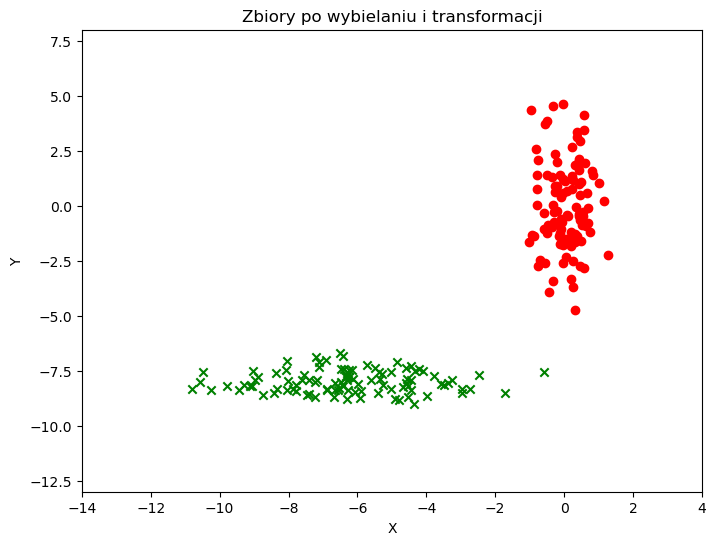

In [42]:
plt.figure(figsize=(8, 6))

plt.scatter(t1[:,[0]], t1[:,[1]], color='red', marker='o')
plt.scatter(t2[:,[0]], t2[:,[1]], color='green', marker='x')

plt.xlabel('X')
plt.ylabel('Y')

plt.xlim(-14, 4)
plt.ylim(-13, 8)

plt.title('Zbiory po wybielaniu i transformacji')
plt.show()

In [95]:
def discriminant_function(matrix, x):
    means = []
    
    for col_idx in range(matrix.shape[1]):
        means.append(test[:,[col_idx]].mean())
    
    matrix_cov = cov_for_dataset(matrix)
    
    d = x - np.array(means)
    
    det_cov = np.linalg.det(matrix_cov)
    inv_cov = np.linalg.inv(matrix_cov)
    res = -0.5 * np.log(det_cov) - np.dot(np.dot(d.T, inv_cov), d)
    
    #print(f'Cov: {matrix_cov}')
    #print(f'Means: {means}')
    #print(f'd: {d}')
    
    return res[0,0]

In [96]:
test = np.array([[2.0, 1.0], [1.0, 3.0] , [1.0, 5.0]])

In [97]:
discriminant_function(test, [1,1])

-13.045228747557779

In [118]:
def probability_func(matrix1, matrix2):
    a = matrix1.shape[0]
    b = matrix2.shape[0]
    
    return [a / (a + b), b / (a + b)]

In [119]:
probability_func(t1, t2)

[0.5, 0.5]

In [136]:
def assign_class(matrix1, matrix2, x, y):
    p = [x, y]
    probability = probability_func(matrix1, matrix2)
    
    matrix1_probability = probability[0]
    matrix2_probability = probability[1]

    a = np.log(matrix1_probability) + discriminant_function(matrix1, p)
    b = np.log(matrix2_probability) + discriminant_function(matrix2, p)

    return [a, b]

In [137]:
def assign_color(matrix1, matrix2, x, y):
    res = assign_class(matrix1, matrix2, x, y)
    a = res[0]
    b = res[1]
    
    if a > b:
        return 0
    elif a == b:
        return 0.5
    else:
        return 1

In [138]:
def assign_borders(matrix1, matrix2, x, y):
    res = assign_class(matrix1, matrix2, x, y)
    a = res[0]
    b = res[1]
    
    if abs(a-b) < 1:
        return 0
    else:
        return 1

In [123]:
STEP = 0.05

In [124]:
import plotly.express as px

In [125]:
rangex = np.arange(-25, 25 + STEP, STEP)
rangey = rangex

In [134]:
heatmap_data = np.array([[assign_color(t1, t2, x, y) for y in rangey] for x in rangex])

KeyboardInterrupt: 

In [ ]:
heatmap_data = []

for x in rangex:
    row = []
    for y in rangey:
        color = assign_color(x, y)  # Tutaj użyj swojej funkcji assign_color
        row.append(color)
    heatmap_data.append(row)

heatmap_data = np.array(heatmap_data)

### Wnioski

Powyższe testy i zastosowane przykłady pokazują poprawność implementacji operacji transformacji (obrót i rozciąganie) zbioru danych.